In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold


In [2]:
df = pd.read_csv('nba_engineered_game_df.csv')
df = df.sort_values(by=['date']).reset_index(drop=True)
pd.set_option('display.max_columns', None)
df.head(6)

,Team_A,Team_B,matchup_id,date,Team_A_+/-_basic_max,Team_A_DRtg_advanced_max,Team_A_DRtg_advanced_totals,Team_A_FG%_basic_totals,Team_A_GmSc_basic_max,Team_A_ORtg_advanced_totals,Team_A_PTS_basic_max,Team_A_PTS_basic_totals,Team_A_TS%_advanced_totals,Team_A_eFG%_advanced_totals,Team_B_+/-_basic_max,Team_B_DRtg_advanced_max,Team_B_DRtg_advanced_totals,Team_B_ORtg_advanced_totals,Team_B_TS%_advanced_totals,Team_A_win,Team_A_home,Team_A_win_next,next_matchup_date,Team_A_win_last5,Team_A_+/-_basic_max_last5,Team_A_DRtg_advanced_totals_last5,Team_A_FG%_basic_totals_last5,Team_A_FG_basic_max_last5,Team_A_GmSc_basic_max_last5,Team_A_ORtg_advanced_max_last5,Team_A_ORtg_advanced_totals_last5,Team_A_PTS_basic_max_last5,Team_A_Q1_last5,Team_A_TS%_advanced_totals_last5,Team_A_USG%_advanced_max_last5,Team_A_eFG%_advanced_totals_last5,Team_B_win_last5,Team_B_+/-_basic_max_last5,Team_B_3PAr_advanced_max_last5,Team_B_DRtg_advanced_max_last5,Team_B_DRtg_advanced_totals_last5,Team_B_FG%_basic_totals_last5,Team_B_GmSc_basic_max_last5,Team_B_ORtg_advanced_max_last5,Team_B_ORtg_advanced_totals_last5,Team_B_PTS_basic_max_last5,Team_B_TRB%_advanced_totals_last5,Team_B_TS%_advanced_max_last5,Team_B_TS%_advanced_totals_last5,Team_B_eFG%_advanced_max_last5,Team_B_eFG%_advanced_totals_last5,Team_A_win_last10,Team_A_+/-_basic_max_last10,Team_A_3P%_basic_totals_last10,Team_A_DRtg_advanced_max_last10,Team_A_DRtg_advanced_totals_last10,Team_A_FG%_basic_totals_last10,Team_A_FGA_basic_max_last10,Team_A_FG_basic_max_last10,Team_A_FT_basic_max_last10,Team_A_GmSc_basic_max_last10,Team_A_ORtg_advanced_max_last10,Team_A_ORtg_advanced_totals_last10,Team_A_PTS_basic_max_last10,Team_A_PTS_basic_totals_last10,Team_A_Q1_last10,Team_A_TRB%_advanced_totals_last10,Team_A_TS%_advanced_max_last10,Team_A_TS%_advanced_totals_last10,Team_A_USG%_advanced_max_last10,Team_A_eFG%_advanced_totals_last10,Team_B_win_last10,Team_B_+/-_basic_max_last10,Team_B_3P%_basic_totals_last10,Team_B_3PAr_advanced_max_last10,Team_B_DRB_basic_totals_last10,Team_B_DRtg_advanced_max_last10,Team_B_DRtg_advanced_totals_last10,Team_B_FG%_basic_totals_last10,Team_B_FG_basic_max_last10,Team_B_FT_basic_max_last10,Team_B_GmSc_basic_max_last10,Team_B_ORtg_advanced_max_last10,Team_B_ORtg_advanced_totals_last10,Team_B_PTS_basic_max_last10,Team_B_PTS_basic_totals_last10,Team_B_TRB%_advanced_totals_last10,Team_B_TS%_advanced_max_last10,Team_B_TS%_advanced_totals_last10,Team_B_USG%_advanced_max_last10,Team_B_eFG%_advanced_max_last10,Team_B_eFG%_advanced_totals_last10,H2H_last5_Team_A_+/-_basic_max,H2H_last5_Team_A_AST_basic_max,H2H_last5_Team_A_AST_basic_totals,H2H_last5_Team_A_BLK_basic_totals,H2H_last5_Team_A_DRB_basic_totals,H2H_last5_Team_A_DRtg_advanced_max,H2H_last5_Team_A_DRtg_advanced_totals,H2H_last5_Team_A_FG%_basic_totals,H2H_last5_Team_A_FG_basic_max,H2H_last5_Team_A_FG_basic_totals,H2H_last5_Team_A_GmSc_basic_max,H2H_last5_Team_A_ORtg_advanced_totals,H2H_last5_Team_A_PTS_basic_max,H2H_last5_Team_A_PTS_basic_totals,H2H_last5_Team_A_Q1,H2H_last5_Team_A_Q3,H2H_last5_Team_A_TRB%_advanced_totals,H2H_last5_Team_A_TRB_basic_totals,H2H_last5_Team_A_TS%_advanced_totals,H2H_last5_Team_A_eFG%_advanced_totals,H2H_last5_Team_B_+/-_basic_max,H2H_last5_Team_B_BLK_basic_totals,H2H_last5_Team_B_DRB_basic_totals,H2H_last5_Team_B_DRtg_advanced_max,H2H_last5_Team_B_DRtg_advanced_totals,H2H_last5_Team_B_FG%_basic_totals,H2H_last5_Team_B_GmSc_basic_max,H2H_last5_Team_B_ORtg_advanced_totals,H2H_last5_Team_B_PTS_basic_totals,H2H_last5_Team_B_Q1,H2H_last5_Team_B_TRB%_advanced_totals,H2H_last5_Team_B_TRB_basic_totals,H2H_last5_Team_B_TS%_advanced_totals,H2H_last5_Team_B_eFG%_advanced_totals,Team_A_Elo_after_current_game,Team_B_Elo_after_current_game,Team_A_Elo_before_next_matchup,Team_B_Elo_before_next_matchup,elo_diff_before_next_matchup,Elo_diff_after_current_game,Team_A_Season_WinPct_after_current,Team_B_Season_WinPct_after_current,Team_A_Season_WinPct_before_next_matchup,Team_B_Season_WinPct_before_next_matchup,Team_A_H2

In [3]:
df = df.drop(columns=['date', 'next_matchup_date', 'matchup_id'])
train_size = int(0.8 * len(df))  
val_size = len(df) - train_size 
#int(0.15 * len(df))   
#test_size = len(df) - train_size - val_size  

y = df['Team_A_win_next']
df = df.drop(columns=['Team_A_win_next'])
x_train = df.iloc[:train_size]
x_val = df.iloc[train_size:]
#x_test = df.iloc[train_size+val_size:]
y_train = y.iloc[:train_size]
y_train = y_train.to_numpy().reshape(-1,1)
y_val = y.iloc[train_size:]
y_val = y_val.to_numpy().reshape(-1,1)
#y_test = y.iloc[train_size+val_size:]
#y_test = y_test.to_numpy().reshape(-1,1)
x_train.shape

(14980, 160)

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [5]:
all_columns = df.columns.tolist()
binary_cols = [col for col in x_train.columns if x_train[col].nunique() == 2]
exclude_cols = set(binary_cols + ['Team_A', 'Team_B'])
normalize_cols = [col for col in all_columns if col not in exclude_cols]
normalize_indices = [all_columns.index(col) for col in normalize_cols]

mean = x_train[normalize_cols].mean().values
std = x_train[normalize_cols].std().values
x_train = x_train.to_numpy()
x_val = x_val.to_numpy()
#x_test = x_test.to_numpy()

x_train[:, normalize_indices] = (x_train[:, normalize_indices] - mean) / std
x_val[:, normalize_indices] = (x_val[:, normalize_indices] - mean) / std
#x_test[:, normalize_indices] = (x_test[:, normalize_indices] - mean) / std

In [6]:
num_features = x_train.shape[1]
w = np.random.normal(0, 0.01, size=(num_features, 1))
b = 0.0
y_train = y_train.reshape(-1, 1)
y_val   = y_val.reshape(-1, 1)
#z = x_train @ w + b
#y_pred = sigmoid(z)

In [7]:
def compute_cost(x, y, w, b):
    m = y.shape[0]
    z = x @ w + b
    y_pred = sigmoid(z)
    loss = - (1/m) * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
    return loss

In [8]:
def compute_gradients(x, y, w, b): 
    m = y.shape[0]
    z = x @ w + b
    y_pred = sigmoid(z)
    dj_dw = (1/m) * x.T @ (y_pred - y) 
    dj_db = (1/m) * np.sum(y_pred - y)
    return dj_dw, dj_db

In [9]:
learning_rate = 0.01
num_epochs = 100
train_cost_history = []
val_cost_history = []

for epoch in range(num_epochs):
    dj_dw, dj_db = compute_gradients(x_train, y_train, w, b)

    w = w - (learning_rate * dj_dw)
    b = b - (learning_rate * dj_db)

    train_cost = compute_cost(x_train, y_train, w, b)
    train_cost_history.append(train_cost) 
    val_cost = compute_cost(x_val, y_val, w, b)
    val_cost_history.append(val_cost) 
    print(f"Epoch {epoch+1}/{num_epochs}, Training Cost: {train_cost:.4f}, Validation Cost: {val_cost:.4f}")


Epoch 1/100, Training Cost: 0.6906, Validation Cost: 0.6986
Epoch 2/100, Training Cost: 0.6825, Validation Cost: 0.6846
Epoch 3/100, Training Cost: 0.6764, Validation Cost: 0.6814
Epoch 4/100, Training Cost: 0.6713, Validation Cost: 0.6761
Epoch 5/100, Training Cost: 0.6669, Validation Cost: 0.6725
Epoch 6/100, Training Cost: 0.6631, Validation Cost: 0.6692
Epoch 7/100, Training Cost: 0.6599, Validation Cost: 0.6665
Epoch 8/100, Training Cost: 0.6571, Validation Cost: 0.6641
Epoch 9/100, Training Cost: 0.6546, Validation Cost: 0.6621
Epoch 10/100, Training Cost: 0.6525, Validation Cost: 0.6604
Epoch 11/100, Training Cost: 0.6506, Validation Cost: 0.6589
Epoch 12/100, Training Cost: 0.6490, Validation Cost: 0.6576
Epoch 13/100, Training Cost: 0.6476, Validation Cost: 0.6565
Epoch 14/100, Training Cost: 0.6463, Validation Cost: 0.6555
Epoch 15/100, Training Cost: 0.6452, Validation Cost: 0.6547
Epoch 16/100, Training Cost: 0.6442, Validation Cost: 0.6539
Epoch 17/100, Training Cost: 0.64

In [10]:
z_val = x_val @ w + b
y_val_probs = sigmoid(z_val)
y_val_pred = (y_val_probs >= 0.5).astype(int)
accuracy = np.mean(y_val_pred == y_val)
print(f"Validation Accuracy: {accuracy * 100:.3f}%")

Validation Accuracy: 62.734%


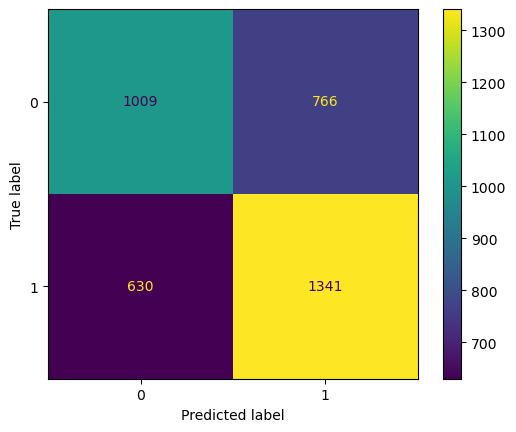

In [11]:
conf_matrix = confusion_matrix(y_val, y_val_pred)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
conf_matrix_display.plot()

In [12]:
tn, fp, fn, tp = conf_matrix.ravel()

tpr = tp / (tp + fn)  
fpr = fp / (fp + tn)  
tnr = tn / (tn + fp)  
fnr = fn / (fn + tp)  
print(f"TPR: {tpr:.4f}")
print(f"FPR: {fpr:.3f}")
print(f"TNR: {tnr:.3f}")
print(f"FNR: {fnr:.3f}")
probs = sigmoid(x_val @ w + b)
auc = roc_auc_score(y_val, probs)
print("AUC:", auc)

TPR: 0.6804
FPR: 0.432
TNR: 0.568
FNR: 0.320
AUC: 0.6729696086207759


In [13]:
'''
DROPPING FEATURES WITH DCOR < 0.08
Validation Accuracy: 62.547%
TPR: 0.7039
FPR: 0.462
TNR: 0.538
FNR: 0.296
AUC: 0.673579778682845

Validation Accuracy: 62.493%
TPR: 0.7145
FPR: 0.475
TNR: 0.525
FNR: 0.285
AUC: 0.6730169383774192

NEW RUN (LATEST W TEAM A HOME NEXY MATCHUP)
Validation Accuracy: 62.840%
TPR: 0.7170
FPR: 0.470
TNR: 0.530
FNR: 0.283
AUC: 0.6751328063006099

Validation Accuracy: 62.547%
TPR: 0.7201
FPR: 0.480
TNR: 0.520
FNR: 0.280
AUC: 0.6733408073799827
'''

'\nDROPPING FEATURES WITH DCOR < 0.08\nValidation Accuracy: 62.547%\nTPR: 0.7039\nFPR: 0.462\nTNR: 0.538\nFNR: 0.296\nAUC: 0.673579778682845\n\nValidation Accuracy: 62.493%\nTPR: 0.7145\nFPR: 0.475\nTNR: 0.525\nFNR: 0.285\nAUC: 0.6730169383774192\n\nNEW RUN (LATEST W TEAM A HOME NEXY MATCHUP)\nValidation Accuracy: 62.840%\nTPR: 0.7170\nFPR: 0.470\nTNR: 0.530\nFNR: 0.283\nAUC: 0.6751328063006099\n\nValidation Accuracy: 62.547%\nTPR: 0.7201\nFPR: 0.480\nTNR: 0.520\nFNR: 0.280\nAUC: 0.6733408073799827\n'